<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 


<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Deep  Autoencoder- Noisey manifold </h1>

<h2>Table of Contents</h2>
<p>In this lab, you will create a deep autoencoder for noise removal in a non-linear manifold..</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#Model_Cost">Function to Train, the Model </a></li>
    <li><a href="#CM">Build Custom  module </a></li>
    <li><a href="#tv">Training and Validate Model </a></li>
</ul>

<p>Estimated Time Needed: <strong>20 min</strong></p>

<hr>

<h2>Preparation</h2>

We'll need the following libraries

In [6]:
# Import the libraries we need for the lab

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0) 

<!--Empty Space for separating topics-->

Create a noisy manifold dataset class example:

In [7]:
# Create Data object

class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=400, noise_std=0.1, train=True):
        self.x=torch.zeros(( N_SAMPLES,2))
        self.x_=torch.zeros(( N_SAMPLES,2))
    
        self.x[:,0] = torch.linspace(-2, 2, N_SAMPLES)
        
        self.x[:,1] = (self.x[:,0] **3)
        self.len=N_SAMPLES
        if train != True:
            torch.manual_seed(1)
            self.x_[:,0] = self.x[:,0]+ noise_std * torch.randn(N_SAMPLES)
            self.x_[:,1] = self.x[:,1]+ noise_std * torch.randn(N_SAMPLES)
            
        else:
            torch.manual_seed(0)
            self.x_[:,0] = self.x[:,0]+ noise_std * torch.randn(N_SAMPLES)
            self.x_[:,1] = self.x[:,1]+ noise_std * torch.randn(N_SAMPLES)
    
    # Getter
    def __getitem__(self, index):    
        return self.x_[index,:], self.x[index,:]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot(self):
        plt.figure(figsize = (6.1, 10))
        plt.scatter(self.x_[:,0].numpy(),self.x_[:,1].numpy(), label="Noisy function")
        plt.plot(self.x[:,0].numpy(), self.x[:,1].numpy() ,label="True Function", color='orange')
        plt.xlabel("x_{1}")
        plt.ylabel("x_{2}")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

This example will be used to plot the data.

In [8]:
def plot_points(model,dataset,title="autoencoder"):

    xhat_points=model(dataset.x_)
    f_xat=model(dataset.x)

    ax=plt.subplot(121)
    ax.scatter(xhat_points[:,0].detach().numpy(),xhat_points[:,1].detach().numpy(), label="xhat")
    ax.scatter(dataset.x_[:,0].numpy(),dataset.x_[:,1].numpy(), label="xhat")
    ax.plot(f_xat[:,0].detach().numpy(), f_xat[:,1].detach().numpy() ,label="fhat", color='r')
    ax.plot(dataset.x[:,0].numpy(), dataset.x[:,1].numpy(),'g' ,label="f",)
    ax.set_title(title)
    ax.legend() 
    plt.show()  

<h2 id="Makeup_Data">Make Some Data</h2>

Create a dataset object for training:

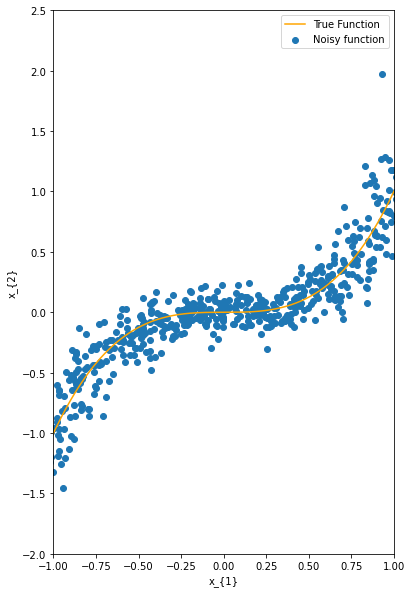

In [9]:
# Create the dataset object and plot the dataset

train_dataset = Data(N_SAMPLES=1000, noise_std=0.1)
train_dataset .plot()


Create a dataset object for validation data: 

In [10]:
# Create validation dataset object

validation_dataset = Data(N_SAMPLES=400, noise_std=0.1,train=False)
len(train_dataset)

1000

Validiaon loader:

In [11]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset , batch_size=2)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=2)

<!--Empty Space for separating topics-->

<h2 id="Model_Cost">Create the Model, Optimizer, and Total Loss Function (Cost)</h2>

Create a function to train the autoencoder:

In [12]:
def train_model(model,train_loader,validation_loader,optimizer,n_epochs=4):   
    #global variable 
    cost_list_training =[]
    cost_list_validation =[]
    for epoch in range(n_epochs):
        cost_training=0
        for x_tilde, x in train_loader:
           
            model.train()
            optimizer.zero_grad()
            xhat = model(x_tilde)
            loss = criterion(xhat , x)
            loss.backward()
            optimizer.step()
            cost_training+=loss.data
        
        cost_list_training.append(cost_training)
    
       

        #perform a prediction on the validation  data  
        cost_val=0
        for x_test, y_test in validation_loader:
            
            model.eval()
            z = model(x_test)
            loss = criterion(z, x_test)
            cost_val+=loss.data
            
            
        
        cost_list_validation.append(cost_val)
     
    return cost_list_training, cost_list_validation

This function will plot the training cost and validation cost.

In [13]:
def plot_train_val(cost_list,accuracy_list,val_data_label ='accuracy'):

    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost_list, color = color)
    ax1.set_xlabel('epoch ', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(val_data_label, color = color)  # we already handled the x-label with ax1
    ax2.plot(accuracy_list, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()
    plt.show()

<h2 id="CM">Build Custom  module  </h2>

Create Autoencoder custom modules:

<b>Linear autoencoder:</b>

In [14]:
class AutoEncoder(nn.Module):
    
    # Contructor
    def __init__(self, input_dim=2, encoding_dim=2):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Linear(input_dim,encoding_dim)
        self.decoder = nn.Linear(encoding_dim,input_dim)
    
    # Prediction
    def forward(self, x):
        x =  self.encoder(x)
        
        x=self.decoder(x)
      
        return x
    
    def code(self,x):
        return self.encoder(x)

<b>Shallow  Nonlinear Decoding and Encoding Function </b> 

In [15]:
 class AutoEncoder_s(nn.Module):   
    def __init__(self, input_dim=2, encoding_dim=2):
        super(AutoEncoder_s, self).__init__()
        
        self.encoder = nn.Linear(input_dim,encoding_dim)
        self.decoder = nn.Linear(encoding_dim,input_dim)
    
    # Prediction
    def forward(self, x):
        x =  torch.sigmoid(self.encoder(x))
        
        x=torch.selu(self.decoder(x))
      
        return x
    
    def code(self,x):
        return self.encoder(x)

<b>Deep autoencoder  Nonlinear Decoding and Encoding Function</b> 

In [16]:
class Autoencoderone_hidden(nn.Module):
    def __init__(self, input_dim=2,encoding_dim_1=2,encoding_dim_2=2):
        super(Autoencoderone_hidden,self).__init__()
      
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim_1),
            nn.Tanh(),
            nn.Linear(encoding_dim_1, encoding_dim_2))
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim_2, encoding_dim_1),
            nn.Tanh(),
            nn.Linear(encoding_dim_1, input_dim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
   
        

<h2 id="tv">Training and Validate Model </h2>

In this section, we will train and validate the different autoencoders. We have the linear autoencoder:

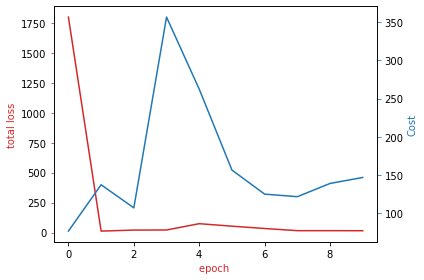

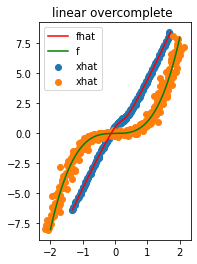

In [17]:
model_linear=AutoEncoder(2,1000)
criterion = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model_linear.parameters(), lr = learning_rate)
accuracy_list, lost_list=train_model(model=model_linear,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)
plot_train_val(accuracy_list, lost_list,val_data_label ='Cost')

plot_points(model_linear,validation_dataset,"linear overcomplete ")

we have the shallow autoencoder 

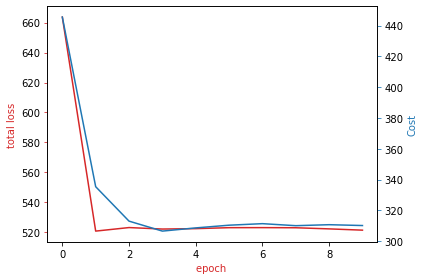

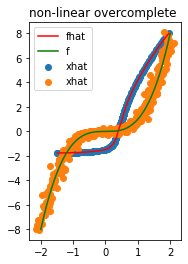

In [18]:
model_relu=AutoEncoder_s(2,1000)
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model_relu.parameters(), lr = learning_rate)
accuracy_list, lost_list=train_model(model=model_relu,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)
plot_train_val(accuracy_list, lost_list,val_data_label ='Cost')
plot_points(model_relu,validation_dataset,"non-linear overcomplete ")

finally, we have the deep autoencoder 

In [ ]:

model=Autoencoderone_hidden(2,20,20)
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
accuracy_list, lost_list=train_model(model=model,n_epochs=20,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)
plot_train_val(accuracy_list, lost_list,val_data_label ='Cost')
plt.show()
plot_points(model,validation_dataset,"deep overcomplete ")

We see the deep autoencoder performs better on the training and validation data.

<!--Empty Space for separating topics-->

<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

<hr>

Copyright &copy; 2020 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.